Acknowledgement from: 
https://towardsdatascience.com/how-to-build-a-simple-recommender-system-in-python-375093c3fb7d
https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

In [2]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
matplotlib.style.use('ggplot')

In [4]:
def resumetable(df):
    '''show dataframe summary'''
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary

# Goodreads Book Reviews

In [15]:
books_metadata = pd.read_json('goodreads_books_poetry.json', lines=True)
interactions = pd.read_json('goodreads_interactions_poetry.json', lines=True)

## Books Features cleaning

In [25]:
books_metadata.sample(2)

isbn  text_reviews_count    series country_code language_code  \
11014  0001035231                   3        []           US           eng   
4565                               65  [665397]           US                 

                                         popular_shelves asin is_ebook  \
11014  [{'count': '342', 'name': 'to-read'}, {'count'...         false   
4565   [{'count': '396', 'name': 'to-read'}, {'count'...         false   

       average_rating kindle_asin  \
11014            4.05               
4565             4.07               

                                           similar_books  \
11014  [4860, 10016918, 389469, 428495, 244242, 17348...   
4565   [9859649, 8471387, 5865559, 6593508, 7627932, ...   

                                             description          format  \
11014  Here are some of Shakespeare's finest speeches...  Audio Cassette   
4565   m ldhy ynquSuny\nmdma `indy l'malu ?\nm ldhy y...                   

                                                    link  \
11014  https://www.goodreads.com/book/show/382729.Age...   
4565      https://www.goodreads.com/book/show/13410145-4   

                                                 authors  \
11014  [{'author_id': '947', 'role': ''}, {'author_id...   
4565              [{'author_id': '2128839', 'role': ''}]   

                  publisher num_pages publication_day         isbn13  \
11014  Harper Collins Audio                            9780001035232   
4565                              166                                  

      publication_month edition_information publication_year  \
11014                                                   1992   
4565                                                    1992   

                                                     url  \
11014  https://www.goodreads.com/book/show/382729.Age...   
4565      https://www.goodreads.com/book/show/13410145-4   

                                               image_url   book_id  \
11014  https://s.gr-assets.com/assets/nophoto/book/11...    382729   
4565   https://images.gr-assets.com/books/1388081493m...  13410145   

       ratings_count   work_id                                   title  \
11014             55   1141990  Ages of Man: Readings from Shakespeare   
4565             326  18650985                                لافتات 4   

                         title_without_series  
11014  Ages of Man: Readings from Shakespeare  
4565                                 لافتات 4

In [26]:
books_metadata.shape

(36514, 29)

- The data set contains 36514 distinct books.
- Each book has 29 corresponding features.

In [37]:
# Limit the books metadata to selected fields
books_metadata_selected = books_metadata[['book_id',  'average_rating', 'is_ebook',  'format','popular_shelves','num_pages', 
                                          'publisher','publication_year', 'ratings_count', 'language_code', 
                                          'description','title', 'title_without_series']]
books_metadata_selected.sample(3)

book_id  average_rating is_ebook     format  \
26178   1559633            4.31    false              
27707   1440776            4.44    false  Paperback   
12387  18072399            3.56    false              

                                         popular_shelves num_pages  \
26178  [{'count': '484', 'name': 'to-read'}, {'count'...             
27707  [{'count': '6', 'name': 'to-read'}, {'count': ...             
12387  [{'count': '9', 'name': 'to-read'}, {'count': ...             

          publisher publication_year  ratings_count language_code  \
26178                           2007            972                 
27707  Pocket Books             1981             16                 
12387       l'ecrou             2013             16                 

                                             description              title  \
26178  bwstn s`dy br ss nskhh tSHyH shdh mHmd`ly frwG...        بوستان سعدی   
27707                                                     LOOKNG FOR FRIEND   
12387  Coeur takeout, c'est une bonne dose d'amour, c...      coeur takeout   

      title_without_series  
26178          بوستان سعدی  
27707    LOOKNG FOR FRIEND  
12387        coeur takeout

In [38]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        # Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names
    # Return empty list in case of missing/malformed data
    return []


def remove_list(lst):
    return str(lst).strip('[]')

In [39]:
books_metadata_selected['popular_shelves'] = books_metadata_selected['popular_shelves'].apply(get_list)
books_metadata_selected['popular_shelves'] = books_metadata_selected['popular_shelves'].apply(remove_list)

In [40]:
resumetable(books_metadata_selected)

Dataset Shape: (36514, 13)


Name   dtypes  Missing  Uniques  \
0                book_id    int64        0    36514   
1         average_rating  float64        0      282   
2               is_ebook   object        0        2   
3                 format   object        0      197   
4        popular_shelves   object        0     6991   
5              num_pages   object        0     1059   
6              publisher   object        0     8186   
7       publication_year   object        0      202   
8          ratings_count    int64        0     1725   
9          language_code   object        0       93   
10           description   object        0    25715   
11                 title   object        0    29727   
12  title_without_series   object        0    29727   

                                          First Value  \
0                                            16037549   
1                                                3.83   
2                                               false   
3                                           Paperback   
4            'to-read', 'poetry', 'currently-reading'   
5                                                  80   
6                       Houghton, Mifflin and Company   
7                                                1887   
8                                                   3   
9                                                 eng   
10  Number 30 in a series of literary pamphlets pu...   
11              Vision of Sir Launfal and Other Poems   
12              Vision of Sir Launfal and Other Poems   

                                         Second Value  \
0                                            22466716   
1                                                3.83   
2                                               false   
3                                           Paperback   
4             'to-read', 'currently-reading', 'drama'   
5                                                 128   
6                                      New Directions   
7                                                2015   
8                                                  37   
9                                                       
10  Fairy Tales gathers the unconventional verse d...   
11                           Fairy Tales: Dramolettes   
12                           Fairy Tales: Dramolettes   

                                          Third Value  
0                                              926662  
1                                                4.38  
2                                               false  
3                                           Paperback  
4                'to-read', 'poetry', 'picture-books'  
5                                                      
6                                Farrar Straus Giroux  
7                                                2008  
8                                                  45  
9                                                      
10  Three poems describe the nighttime adventures ...  
11            Growltiger's Last Stand and Other Poems  
12            Growltiger's Last Stand and Other Poems

In [41]:
# replace blank cells with NaN
books_metadata_selected.replace('', np.nan, inplace=True)
resumetable(books_metadata_selected)

Dataset Shape: (36514, 13)


Name   dtypes  Missing  Uniques  \
0                book_id    int64        0    36514   
1         average_rating  float64        0      282   
2               is_ebook   object        0        2   
3                 format   object     7025      196   
4        popular_shelves   object        0     6991   
5              num_pages   object     7505     1058   
6              publisher   object     6033     8185   
7       publication_year   object     5816      201   
8          ratings_count    int64        0     1725   
9          language_code   object    19462       92   
10           description   object     7526    25714   
11                 title   object        2    29726   
12  title_without_series   object        2    29726   

                                          First Value  \
0                                            16037549   
1                                                3.83   
2                                               false   
3                                           Paperback   
4            'to-read', 'poetry', 'currently-reading'   
5                                                  80   
6                       Houghton, Mifflin and Company   
7                                                1887   
8                                                   3   
9                                                 eng   
10  Number 30 in a series of literary pamphlets pu...   
11              Vision of Sir Launfal and Other Poems   
12              Vision of Sir Launfal and Other Poems   

                                         Second Value  \
0                                            22466716   
1                                                3.83   
2                                               false   
3                                           Paperback   
4             'to-read', 'currently-reading', 'drama'   
5                                                 128   
6                                      New Directions   
7                                                2015   
8                                                  37   
9                                                 NaN   
10  Fairy Tales gathers the unconventional verse d...   
11                           Fairy Tales: Dramolettes   
12                           Fairy Tales: Dramolettes   

                                          Third Value  
0                                              926662  
1                                                4.38  
2                                               false  
3                                           Paperback  
4                'to-read', 'poetry', 'picture-books'  
5                                                 NaN  
6                                Farrar Straus Giroux  
7                                                2008  
8                                                  45  
9                                                 NaN  
10  Three poems describe the nighttime adventures ...  
11            Growltiger's Last Stand and Other Poems  
12            Growltiger's Last Stand and Other Poems

- Lots of columns have missing values, require further cleaning

In [42]:
# using pandas to convert pages into numeric values
books_metadata_selected['num_pages'].replace(np.nan, -1, inplace=True)
books_metadata_selected['num_pages'] = pd.to_numeric(books_metadata_selected['num_pages'])

# rounding ratings to neares .5 score
books_metadata_selected['average_rating'] = books_metadata_selected['average_rating'].apply(lambda x: round(x*2)/2)

# replacing missing values to 'unknown'
books_metadata_selected['language_code'].replace(np.nan, 'unknown', inplace=True)
books_metadata_selected['format'].replace(np.nan, 'unknown', inplace=True)
books_metadata_selected['publisher'].replace(np.nan, 'unknown', inplace=True)

# replacing missing values to year 2100
books_metadata_selected['publication_year'].replace(np.nan, 2100, inplace=True)
books_metadata_selected.dropna(inplace=True)

resumetable(books_metadata_selected)

Dataset Shape: (28987, 13)


Name   dtypes  Missing  Uniques  \
0                book_id    int64        0    28987   
1         average_rating  float64        0       10   
2               is_ebook   object        0        2   
3                 format   object        0      134   
4        popular_shelves   object        0     5491   
5              num_pages    int64        0      991   
6              publisher   object        0     6806   
7       publication_year   object        0      179   
8          ratings_count    int64        0     1635   
9          language_code   object        0       88   
10           description   object        0    25713   
11                 title   object        0    23460   
12  title_without_series   object        0    23460   

                                          First Value  \
0                                            16037549   
1                                                   4   
2                                               false   
3                                           Paperback   
4            'to-read', 'poetry', 'currently-reading'   
5                                                  80   
6                       Houghton, Mifflin and Company   
7                                                1887   
8                                                   3   
9                                                 eng   
10  Number 30 in a series of literary pamphlets pu...   
11              Vision of Sir Launfal and Other Poems   
12              Vision of Sir Launfal and Other Poems   

                                         Second Value  \
0                                            22466716   
1                                                   4   
2                                               false   
3                                           Paperback   
4             'to-read', 'currently-reading', 'drama'   
5                                                 128   
6                                      New Directions   
7                                                2015   
8                                                  37   
9                                             unknown   
10  Fairy Tales gathers the unconventional verse d...   
11                           Fairy Tales: Dramolettes   
12                           Fairy Tales: Dramolettes   

                                          Third Value  
0                                              926662  
1                                                 4.5  
2                                               false  
3                                           Paperback  
4                'to-read', 'poetry', 'picture-books'  
5                                                  -1  
6                                Farrar Straus Giroux  
7                                                2008  
8                                                  45  
9                                             unknown  
10  Three poems describe the nighttime adventures ...  
11            Growltiger's Last Stand and Other Poems  
12            Growltiger's Last Stand and Other Poems

In [33]:
books_metadata_selected.to_csv('book_clean.csv', index=False)

## Users' Interaction Cleaning

In [16]:
resumetable(interactions)

Dataset Shape: (2734350, 10)


Name  dtypes  Missing  Uniques  \
0                 user_id  object        0   377799   
1                 book_id   int64        0    36514   
2               review_id  object        0  2734350   
3                 is_read    bool        0        2   
4                  rating   int64        0        6   
5  review_text_incomplete  object        0   153015   
6              date_added  object        0  2701952   
7            date_updated  object        0  2648504   
8                 read_at  object        0   247036   
9              started_at  object        0   153937   

                        First Value                      Second Value  \
0  8842281e1d1347389f2ab93d60773d4d  8842281e1d1347389f2ab93d60773d4d   
1                              1384                              1376   
2  1bad0122cebb4aa9213f9fe1aa281f66  eb6e502d0c04d57b43a5a02c21b64ab4   
3                              True                              True   
4                                 4                                 4   
5                                                                       
6    Wed May 09 09:33:44 -0700 2007    Wed May 09 09:33:18 -0700 2007   
7    Wed May 09 09:33:44 -0700 2007    Wed May 09 09:33:18 -0700 2007   
8                                                                       
9                                                                       

                        Third Value  
0  8842281e1d1347389f2ab93d60773d4d  
1                             30119  
2  787564bef16cb1f43e0f641ab59d25b7  
3                              True  
4                                 5  
5                                    
6    Sat Jan 13 13:44:20 -0800 2007  
7    Wed Mar 22 11:45:08 -0700 2017  
8    Tue Mar 01 00:00:00 -0800 1983  
9

- The dataset contains 2,734,350 users interactions.

In [48]:
# Limit the books metadata to selected fields
interactions_selected = interactions[['user_id', 'book_id', 'is_read', 'rating']]
resumetable(interactions_selected)

Dataset Shape: (2734350, 4)


Name  dtypes  Missing  Uniques                       First Value  \
0  user_id  object        0   377799  8842281e1d1347389f2ab93d60773d4d   
1  book_id   int64        0    36514                              1384   
2  is_read    bool        0        2                              True   
3   rating   int64        0        6                                 4   

                       Second Value                       Third Value  
0  8842281e1d1347389f2ab93d60773d4d  8842281e1d1347389f2ab93d60773d4d  
1                              1376                             30119  
2                              True                              True  
3                                 4                                 5

In [49]:
interactions_selected.groupby(['rating', 'is_read']).size().reset_index().pivot(columns='rating', index='is_read', values=0)

rating           0        1        2         3         4         5
is_read                                                           
False    1420740.0      NaN      NaN       NaN       NaN       NaN
True       84551.0  20497.0  64084.0  237942.0  405565.0  500971.0

- From the above results, we can conclusively infer that users with ratings >= 1 have all read the book. 
- Therefore, we'll use the **ratings** as the final score.
- Drop interactions where **is_read** is false.

In [50]:
interactions_selected = interactions_selected[interactions_selected['is_read']==1]
interactions_selected = interactions_selected[['user_id', 'book_id', 'rating']]
interactions_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313610 entries, 0 to 2734349
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1313610 non-null  object
 1   book_id  1313610 non-null  int64 
 2   rating   1313610 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 40.1+ MB


In [20]:
interactions_selected.to_csv('review_clean.csv', index=False)

## Data Preprocessing Books

In [43]:
interactions_selected.user_id.nunique()

282414

In [44]:
## create a map from book_id to title
item_dict ={}
df = books_metadata[['book_id', 'title']].sort_values('book_id').reset_index()
for i in range(df.shape[0]):
    item_dict[(df.loc[i,'book_id'])] = df.loc[i,'title']
item_dict

{234: 'The Complete Verse and Other Nonsense',
 236: 'The Complete Nonsense of Edward Lear',
 241: 'A Was Once an Apple Pie',
 244: 'The Puffin Book Of Nonsense Verse',
 254: 'The Time of the Assassins:  a Study of Rimbaud',
 284: 'A Treasury of Kahlil Gibran',
 285: 'Love Letters',
 286: 'The Prophet',
 289: 'The Beloved: Reflections on the Path of the Heart',
 290: 'Jesus the Son of Man',
 291: 'The Broken Wings',
 292: 'Sand and Foam',
 448: 'A Tomb for Anatole: Poetry',
 459: 'The Random House Book of 20th Century French Poetry',
 462: 'Disappearances',
 464: 'Collected Poems',
 484: "Reinventing the Enemy's Language: Contemporary Native Women's Writings of North America",
 676: 'Sailing Alone Around the Room: New and Selected Poems',
 1079: 'For the Good of the Earth and Sun: Teaching Poetry',
 1371: 'The Iliad',
 1372: 'The Iliad',
 1373: 'Iliad',
 1374: 'The Iliad',
 1376: 'The Iliad',
 1377: 'The Iliad',
 1378: 'The Essential Iliad',
 1380: 'The Iliad',
 1381: 'The Odyssey',
 1

In [45]:
# dummify categorical features
books_metadata_selected_transformed = pd.get_dummies(books_metadata_selected, columns = ['average_rating', 'is_ebook', 
                                                                                         'publication_year', 'ratings_count', 
                                                                                         'language_code'])
books_metadata_selected_transformed = books_metadata_selected_transformed.sort_values('book_id').reset_index().drop('index', axis=1)
books_metadata_selected_transformed.head(3)

book_id     format                           popular_shelves  num_pages  \
0      234    unknown              'to-read', 'poetry', 'humor'         -1   
1      236  Hardcover  'to-read', 'poetry', 'currently-reading'        287   
2      241  Hardcover    'to-read', 'picture-books', 'alphabet'         32   

         publisher                                        description  \
0          unknown  This collection demonstrates the varied ways i...   
1  Amereon Limited  The Owl and the Pussy-Cat, Calico Pie and The ...   
2    Orchard Books  Hand painted cut paper artwork by Caldecott wi...   

                                   title  \
0  The Complete Verse and Other Nonsense   
1   The Complete Nonsense of Edward Lear   
2                A Was Once an Apple Pie   

                    title_without_series  average_rating_0.0  \
0  The Complete Verse and Other Nonsense                   0   
1   The Complete Nonsense of Edward Lear                   0   
2                A Was Once an Apple Pie                   0   

   average_rating_1.0  average_rating_1.5  average_rating_2.0  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   

   average_rating_2.5  average_rating_3.0  average_rating_3.5  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   1   

   average_rating_4.0  average_rating_4.5  average_rating_5.0  is_ebook_false  \
0                   1                   0                   0               1   
1                   1                   0                   0               1   
2                   0                   0                   0               1   

   is_ebook_true  publication_year_2100  publication_year_0  \
0              0                      1                   0   
1              0                      0                   0   
2              0                      0                   0   

   publication_year_1321  publication_year_1353  publication_year_1356  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   

   publication_year_1361  publication_year_1368  publication_year_1369  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   

   publication_year_1370  publication_year_1371  publication_year_1373  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   

   publication_year_1374  publication_year_1375  publication_year_1378  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   

   publication_year_1382  publication_year_1384  publication_year_1386  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   

   publication_year_1388  publication_year_1389  publication_year_1390  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   

   publication_year_1391  publication_year_148  publication_year_1500  \
0       

In [46]:
books_metadata_selected_transformed.shape

(28987, 1922)

In [87]:
# convert to csr matrix
from scipy.sparse import csr_matrix
books_metadata_csr = csr_matrix(books_metadata_selected_transformed.drop('book_id', axis=1).values)
books_metadata_csr

<36514x357 sparse matrix of type '<class 'numpy.uint8'>'
	with 219084 stored elements in Compressed Sparse Row format>

## Data Processing interaction

In [103]:
user_book_interaction = pd.pivot_table(interactions_selected, index='user_id', columns='book_id', values='rating')
# fill missing values with 0
user_book_interaction = user_book_interaction.fillna(0)
user_book_interaction.head(10)

IndexError: index 1682324087 is out of bounds for axis 0 with size 1682309830

In [99]:
user_id = list(user_book_interaction.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1
# convert to csr matrix
user_book_interaction_csr = csr_matrix(user_book_interaction.values)
user_book_interaction_csr

<5000x6636 sparse matrix of type '<class 'numpy.float64'>'
	with 19949 stored elements in Compressed Sparse Row format>

In [97]:
user_book_interaction.shape
## 5000 users, 6636 books

(5000, 6636)

# **Demographic Filtering** -
   Before getting started with this  -
* we need a metric to score or rate movie 
* Calculate the score for every movie 
* Sort the scores and recommend the best rated movie to the users.

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes.
So, I'll be using IMDB's weighted rating (wr) which is given as :-

![](https://image.ibb.co/jYWZp9/wr.png)
where,
* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

We already have v(**vote_count**) and R (**vote_average**) and C can be calculated as 

In [62]:
df = pd.read_csv('book_clean.csv')
resumetable(df)

Dataset Shape: (28987, 13)


Name   dtypes  Missing  Uniques  \
0                book_id    int64        0    28987   
1         average_rating  float64        0       10   
2               is_ebook     bool        0        2   
3                 format   object        0      134   
4        popular_shelves   object        0     5491   
5              num_pages    int64        0      991   
6              publisher   object        0     6806   
7       publication_year    int64        0      179   
8          ratings_count    int64        0     1635   
9          language_code   object        0       88   
10           description   object        0    25713   
11                 title   object        0    23460   
12  title_without_series   object        0    23460   

                                          First Value  \
0                                            16037549   
1                                                   4   
2                                               False   
3                                           Paperback   
4            'to-read', 'poetry', 'currently-reading'   
5                                                  80   
6                       Houghton, Mifflin and Company   
7                                                1887   
8                                                   3   
9                                                 eng   
10  Number 30 in a series of literary pamphlets pu...   
11              Vision of Sir Launfal and Other Poems   
12              Vision of Sir Launfal and Other Poems   

                                         Second Value  \
0                                            22466716   
1                                                   4   
2                                               False   
3                                           Paperback   
4             'to-read', 'currently-reading', 'drama'   
5                                                 128   
6                                      New Directions   
7                                                2015   
8                                                  37   
9                                             unknown   
10  Fairy Tales gathers the unconventional verse d...   
11                           Fairy Tales: Dramolettes   
12                           Fairy Tales: Dramolettes   

                                          Third Value  
0                                              926662  
1                                                 4.5  
2                                               False  
3                                           Paperback  
4                'to-read', 'poetry', 'picture-books'  
5                                                  -1  
6                                Farrar Straus Giroux  
7                                                2008  
8                                                  45  
9                                             unknown  
10  Three poems describe the nighttime adventures ...  
11            Growltiger's Last Stand and Other Poems  
12            Growltiger's Last Stand and Other Poems

In [75]:
df['length']=df['title'].apply(len)
df=df[df['length']<=30]

In [76]:
C= df['average_rating'].mean()
C

4.056199077255325

So, the mean rating for all the movies is approx 4 on a scale of 5.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [77]:
m= df['ratings_count'].quantile(0.8)
m

104.0

In [78]:
books_df = df[df['ratings_count'] >= m]
books_df.shape

(4090, 14)

We see that there are 5818 books which qualify to be in this list. Now, we need to calculate our metric for each qualified movie. To do this, we will define a function, **weighted_rating()** and define a new feature **score**, of which we'll calculate the value by applying this function to our DataFrame of qualified movies:

In [79]:
def weighted_rating(df, m=m, C=C):
    v = df['ratings_count']
    R = df['average_rating']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [80]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
books_df['score'] = books_df.apply(weighted_rating, axis=1)
resumetable(books_df)

Dataset Shape: (4090, 15)


Name   dtypes  Missing  Uniques  \
0                book_id    int64        0     4090   
1         average_rating  float64        0        7   
2               is_ebook     bool        0        2   
3                 format   object        0       28   
4        popular_shelves   object        0      569   
5              num_pages    int64        0      595   
6              publisher   object        0     1252   
7       publication_year    int64        0       87   
8          ratings_count    int64        0     1303   
9          language_code   object        0       53   
10           description   object        0     3868   
11                 title   object        0     3419   
12  title_without_series   object        0     3419   
13                length    int64        0       30   
14                 score  float64        0     1981   

                                          First Value  \
0                                              926667   
1                                                 3.5   
2                                               False   
3                                           Paperback   
4                         'to-read', 'plays', 'drama'   
5                                                 190   
6                                       Mariner Books   
7                                                1964   
8                                                 115   
9                                             unknown   
10  A modern verse play about the search for meani...   
11                                 The Cocktail Party   
12                                 The Cocktail Party   
13                                                 18   
14                                            3.76413   

                                         Second Value  \
0                                              250810   
1                                                   4   
2                                               False   
3                                             unknown   
4   'to-read', 'rory-gilmore-reading-challenge', '...   
5                                                  -1   
6                                             unknown   
7                                                2100   
8                                                 434   
9                                               en-US   
10  A meaningful play based on the Scopes Monkey T...   
11                                   Inherit the Wind   
12                                   Inherit the Wind   
13                                                 16   
14                                            4.01086   

                                          Third Value  
0                                            24874449  
1                                                 3.5  
2                                               False  
3                                           Paperback  
4      'to-read', 'classics', 'little-black-classics'  
5                                                  64  
6                                    Penguin Classics  
7                                                2015  
8                                                 399  
9                                                 eng  
10  'I truly thought I'd never make it back.'\nTen...  
11                                    Circles of Hell  
12                                    Circles of Hell  
13                                                 15  
14                                              3.615

In [81]:
#Sort books based on score calculated above
books_df = books_df.sort_values('score', ascending=False)

#Print the top 10 bookes
books_df[['title', 'ratings_count', 'average_rating', 'score']].head(10)

title  ratings_count  average_rating     score
17392                   Le Monogramme            597             5.0  4.859978
13239                   Το μονόγραμμα            503             5.0  4.838294
12551          Koncert za 1001 bubanj            112             5.0  4.545577
25558         Where the Sidewalk Ends        1029527             4.5  4.499955
25557            A Light in the Attic         304689             4.5  4.499849
28434  The Complete Stories and Poems         161550             4.5  4.499714
26479       Essential Tales and Poems          60522             4.5  4.499239
10647       The Raven and Other Poems          34934             4.5  4.498683
4153                Les Fleurs du Mal          27904             4.5  4.498352
14017              The Essential Rumi          26829             4.5  4.498286

In [85]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

Text(0.5, 1.0, 'Top Five Trending Books')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


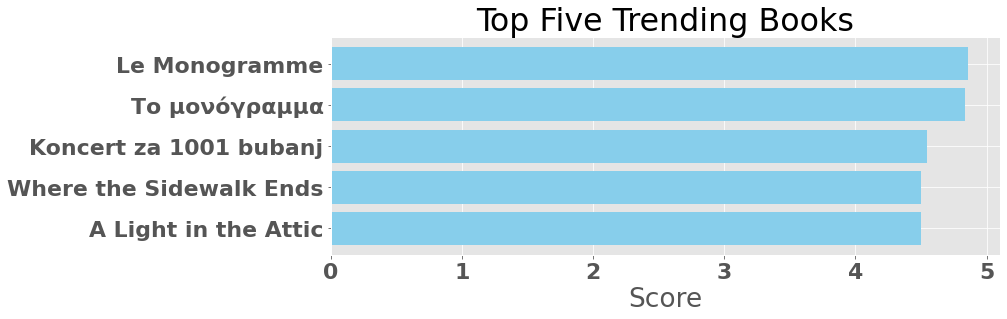

In [86]:
qscore= books_df.sort_values('score', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(qscore['title'].head(5),qscore['score'].head(5), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Score")
plt.title("Top Five Trending Books")

Text(0.5, 1.0, 'Top Six Popular Books')

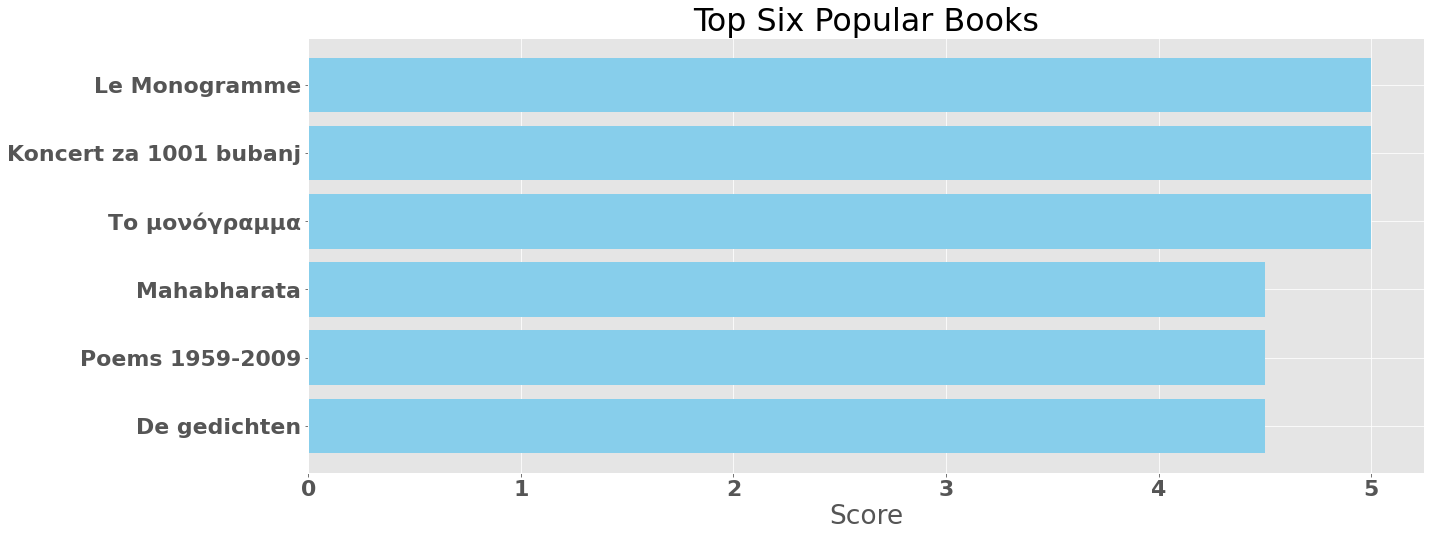

In [87]:
ratings= books_df.sort_values('average_rating', ascending=False)
plt.figure(figsize=(20,8))

plt.barh(ratings['title'].head(6),ratings['average_rating'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Score")
plt.title("Top Six Popular Books")

We have made our first(though very basic) recommender. Under the Trending Now tab of these systems we find books that are very popular and they can just be obtained by sorting the dataset by the popularity column.

# **Content Based Filtering**
In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

![](https://image.ibb.co/f6mDXU/conten.png)

In [88]:
df['description'].tail(5)

28980    In a spring of floods, a son returns to rural ...
28981    How do we discover our deepest desires, those ...
28982    rml w zyd ljbrn khlyl jbrn qmt ldktwr@ nzk sb ...
28984    There was an Old Derry down Derry, who loved t...
28985    'Muse, tell me of a man: a man of much resourc...
Name: description, dtype: object

In [89]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df['description'] = df['description'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(20374, 158978)

In [90]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [91]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df.index, index=df['title']).drop_duplicates()
indices

title
Fairy Tales: Dramolettes        1
The Cocktail Party              3
Su Seviyesi                     5
Into Temptation                 6
Borderlands/La Frontera         7
                            ...  
Ark                         28980
Erotikon: Poems             28981
رمل وزبد                    28982
A Book of Nonsense          28984
Odisea                      28985
Length: 20374, dtype: int64

In [92]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1].any(), reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [93]:
get_recommendations('Le Monogramme')

6             Into Temptation
7     Borderlands/La Frontera
9         Black Liquor: Poems
12          Cornflakes: Poems
13        The More Loving One
14           Inherit the Wind
15                      Ariel
16    Poetry is Not a Project
17            Circles of Hell
18                   The Táin
Name: title, dtype: object

In [101]:
get_recommendations('Not about Heroes')

18                         The Táin
21             Los Papeles Salvajes
52                      L'Amour fou
62                            Split
77               Las flores del mal
82     70 haikus y senryûs de mujer
87                           Ilíada
100                        Teogonía
124                      Mi Pushkin
172        Orientarsi con le stelle
Name: title, dtype: object

In [97]:
get_recommendations('Dear Boy')

3                 The Cocktail Party
6                    Into Temptation
9                Black Liquor: Poems
14                  Inherit the Wind
17                   Circles of Hell
18                          The Táin
24                     Mr. Either/Or
26    100 Poems to Lift Your Spirits
29                         Grashalme
30                      Winter Stars
Name: title, dtype: object

In [102]:
get_recommendations('Romances Sans Paroles')

3                 The Cocktail Party
7            Borderlands/La Frontera
9                Black Liquor: Poems
14                  Inherit the Wind
15                             Ariel
18                          The Táin
26    100 Poems to Lift Your Spirits
29                         Grashalme
32                             Hover
33               It Blows You Hollow
Name: title, dtype: object

# **Credits, Genres and Keywords Based Recommender**
It goes without saying that the quality of our recommender would be increased with the usage of better metadata. That is exactly what we are going to do in this section. We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.

From the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie. Right now, our data is present in the form of "stringified" lists , we need to convert it into a safe and usable structure

In [150]:
resumetable(df)

Dataset Shape: (28987, 13)


Name   dtypes  Missing  Uniques  \
0                book_id    int64        0    28987   
1         average_rating  float64        0      274   
2               is_ebook     bool        0        2   
3                 format   object        0      134   
4        popular_shelves   object        0     5491   
5              num_pages    int64        0      991   
6              publisher   object        0     6806   
7       publication_year    int64        0      179   
8          ratings_count    int64        0     1635   
9          language_code   object        0       88   
10           description   object        0    25713   
11                 title   object        0    23460   
12  title_without_series   object        0    23460   

                                          First Value  \
0                                            16037549   
1                                                3.83   
2                                               False   
3                                           Paperback   
4            'to-read', 'poetry', 'currently-reading'   
5                                                  80   
6                       Houghton, Mifflin and Company   
7                                                1887   
8                                                   3   
9                                                 eng   
10  Number 30 in a series of literary pamphlets pu...   
11              Vision of Sir Launfal and Other Poems   
12              Vision of Sir Launfal and Other Poems   

                                         Second Value  \
0                                            22466716   
1                                                3.83   
2                                               False   
3                                           Paperback   
4             'to-read', 'currently-reading', 'drama'   
5                                                 128   
6                                      New Directions   
7                                                2015   
8                                                  37   
9                                             unknown   
10  Fairy Tales gathers the unconventional verse d...   
11                           Fairy Tales: Dramolettes   
12                           Fairy Tales: Dramolettes   

                                          Third Value  
0                                              926662  
1                                                4.38  
2                                               False  
3                                           Paperback  
4                'to-read', 'poetry', 'picture-books'  
5                                                  -1  
6                                Farrar Straus Giroux  
7                                                2008  
8                                                  45  
9                                             unknown  
10  Three poems describe the nighttime adventures ...  
11            Growltiger's Last Stand and Other Poems  
12            Growltiger's Last Stand and Other Poems

In [144]:
df[['title', 'publisher', 'is_ebook', 'popular_shelves', 'format']].head(3)

title                      publisher  \
0    Vision of Sir Launfal and Other Poems  Houghton, Mifflin and Company   
1                 Fairy Tales: Dramolettes                 New Directions   
2  Growltiger's Last Stand and Other Poems           Farrar Straus Giroux   

   is_ebook                           popular_shelves     format  
0     False  'to-read', 'poetry', 'currently-reading'  Paperback  
1     False   'to-read', 'currently-reading', 'drama'  Paperback  
2     False      'to-read', 'poetry', 'picture-books'  Paperback

In [145]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [151]:
# Apply clean_data function to your features.
features = ['publisher',  'popular_shelves', 'format']

for feature in features:
    df[feature] = df[feature].apply(clean_data)

In [152]:
df[['title', 'publisher', 'is_ebook', 'popular_shelves', 'format']].head(3)

title                   publisher  \
0    Vision of Sir Launfal and Other Poems  houghton,mifflinandcompany   
1                 Fairy Tales: Dramolettes               newdirections   
2  Growltiger's Last Stand and Other Poems          farrarstrausgiroux   

   is_ebook                         popular_shelves     format  
0     False  'to-read','poetry','currently-reading'  paperback  
1     False   'to-read','currently-reading','drama'  paperback  
2     False      'to-read','poetry','picture-books'  paperback

In [155]:
def create_soup(x):
    return ' '.join(x['publisher']) + ' ' + ' ' + x['popular_shelves'] + ' ' + ' '.join(x['format'])
df['soup'] = df.apply(create_soup, axis=1)
df[['title', 'publisher', 'is_ebook', 'popular_shelves', 'format','soup']].head(3)

title                   publisher  \
0    Vision of Sir Launfal and Other Poems  houghton,mifflinandcompany   
1                 Fairy Tales: Dramolettes               newdirections   
2  Growltiger's Last Stand and Other Poems          farrarstrausgiroux   

   is_ebook                         popular_shelves     format  \
0     False  'to-read','poetry','currently-reading'  paperback   
1     False   'to-read','currently-reading','drama'  paperback   
2     False      'to-read','poetry','picture-books'  paperback   

                                                soup  
0  h o u g h t o n , m i f f l i n a n d c o m p ...  
1  n e w d i r e c t i o n s  'to-read','currentl...  
2  f a r r a r s t r a u s g i r o u x  'to-read'...

In [157]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['soup'])

In [158]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [159]:
# Reset index of our main DataFrame and construct reverse mapping as before
df = df.reset_index()
indices = pd.Series(df.index, index=df['title'])

In [160]:
get_recommendations('Cent onze haiku', cosine_sim2)

1                    Fairy Tales: Dramolettes
2     Growltiger's Last Stand and Other Poems
3                          The Cocktail Party
4             Louder Than Everything You Love
5                                 Su Seviyesi
6                             Into Temptation
7                     Borderlands/La Frontera
8           Naked Soul: The Erotic Love Poems
9                         Black Liquor: Poems
10         Little Boy Blue: A Memoir in Verse
Name: title, dtype: object

In [161]:
get_recommendations('Romances Sans Paroles',cosine_sim2)

1                    Fairy Tales: Dramolettes
2     Growltiger's Last Stand and Other Poems
3                          The Cocktail Party
4             Louder Than Everything You Love
5                                 Su Seviyesi
6                             Into Temptation
7                     Borderlands/La Frontera
8           Naked Soul: The Erotic Love Poems
9                         Black Liquor: Poems
10         Little Boy Blue: A Memoir in Verse
Name: title, dtype: object

In [162]:
get_recommendations('Le Monogramme',cosine_sim2)

1                    Fairy Tales: Dramolettes
2     Growltiger's Last Stand and Other Poems
3                          The Cocktail Party
4             Louder Than Everything You Love
5                                 Su Seviyesi
6                             Into Temptation
7                     Borderlands/La Frontera
8           Naked Soul: The Erotic Love Poems
9                         Black Liquor: Poems
10         Little Boy Blue: A Memoir in Verse
Name: title, dtype: object

# **Collaborative Filtering**

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers.
It is basically of two types:-

*  **User based filtering**-  These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity.
This filtering technique can be illustrated with an example. In the following matrixes, each row represents a user, while the columns correspond to different movies except the last one which records the similarity between that user and the target user. Each cell represents the rating that the user gives to that movie. Assume user E is the target.
![](https://cdn-images-1.medium.com/max/1000/1*9NBFo4AUQABKfoUOpE3F8Q.png)

Since user A and F do not share any movie ratings in common with user E, their similarities with user E are not defined in Pearson Correlation. Therefore, we only need to consider user B, C, and D. Based on Pearson Correlation, we can compute the following similarity.
![](https://cdn-images-1.medium.com/max/1000/1*jZIMJzKM1hKTFftHfcSxRw.png)

From the above table we can see that user D is very different from user E as the Pearson Correlation between them is negative. He rated Me Before You higher than his rating average, while user E did the opposite. Now, we can start to fill in the blank for the movies that user E has not rated based on other users.
![](https://cdn-images-1.medium.com/max/1000/1*9TC6BrfxYttJwiATFAIFBg.png)

Although computing user-based CF is very simple, it suffers from several problems. One main issue is that users’ preference can change over time. It indicates that precomputing the matrix based on their neighboring users may lead to bad performance. To tackle this problem, we can apply item-based CF.

* **Item Based Collaborative Filtering** - Instead of measuring the similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity. The major difference is that, with item-based collaborative filtering, we fill in the blank vertically, as oppose to the horizontal manner that user-based CF does. The following table shows how to do so for the movie Me Before You.
![](https://cdn-images-1.medium.com/max/1000/1*LqFnWb-cm92HoMYBL840Ew.png)

It successfully avoids the problem posed by dynamic user preference as item-based CF is more static. However, several problems remain for this method. First, the main issue is ***scalability***. The computation grows with both the customer and the product. The worst case complexity is O(mn) with m users and n items. In addition, ***sparsity*** is another concern. Take a look at the above table again. Although there is only one user that rated both Matrix and Titanic rated, the similarity between them is 1. In extreme cases, we can have millions of users and the similarity between two fairly different movies could be very high simply because they have similar rank for the only user who ranked them both.



In [5]:
df = pd.read_csv('review_clean.csv')
resumetable(df)

Dataset Shape: (1313610, 3)


Name  dtypes  Missing  Uniques                       First Value  \
0  user_id  object        0   282414  8842281e1d1347389f2ab93d60773d4d   
1  book_id   int64        0    36373                              1384   
2   rating   int64        0        6                                 4   

                       Second Value                       Third Value  
0  8842281e1d1347389f2ab93d60773d4d  8842281e1d1347389f2ab93d60773d4d  
1                              1376                             30119  
2                                 4                                 5

- 1,313,610 interactions over 282K users and 36K books

In [6]:
## map user_id from string to int
id_dic = dict([(y,x+1) for x,y in enumerate(sorted(set(df['user_id'])))])
df['user_id'] = df['user_id'].map(id_dic)
resumetable(df)

Dataset Shape: (1313610, 3)


Name dtypes  Missing  Uniques  First Value  Second Value  Third Value
0  user_id  int64        0   282414       150438        150438       150438
1  book_id  int64        0    36373         1384          1376        30119
2   rating  int64        0        6            4             4            5

In [7]:
df.head(3)

user_id  book_id  rating
0   150438     1384       4
1   150438     1376       4
2   150438    30119       5

## Rating matrix

In [53]:
ratings_matrix = ratings.pivot(index='user_id', columns='book_id', values='rating')
user_id = ratings_matrix.index
book_id = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head(3)

(2140, 3127)


book_id  234       236       254       286       290       291       292       \
user_id                                                                         
195           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
366           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
423           NaN       NaN       NaN       NaN       NaN       NaN       NaN   

book_id  676       1371      1372      1373      1374      1376      1381      \
user_id                                                                         
195           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
366           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
423           NaN       NaN       NaN       NaN       NaN       NaN       5.0   

book_id  1382      1383      1384      1388      1392      1414      1416      \
user_id                                                                         
195           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
366           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
423           NaN       NaN       NaN       NaN       NaN       NaN       NaN   

book_id  1420      1421      1432      1433      1434      1436      1463      \
user_id                                                                         
195           5.0       NaN       NaN       NaN       NaN       NaN       NaN   
366           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
423           NaN       NaN       NaN       NaN       NaN       NaN       NaN   

book_id  1465      1466      1467      1470      1494      1496      1516      \
user_id                                                                         
195           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
366           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
423           NaN       NaN       NaN       NaN       NaN       NaN       NaN   

book_id  1519      1713      1715      1727      1730      2544      2545      \
user_id                                                                         
195           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
366           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
423           NaN       NaN       5.0       NaN       NaN       NaN       NaN   

book_id  2547      2549      2696      2701      2711      3048      3049      \
user_id                                                                         
195           2.0       NaN       NaN       NaN       NaN       NaN       NaN   
366           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
423           5.0       NaN       5.0       NaN       NaN       NaN       NaN   

book_id  3050      3768      3775      4194      4703      5289      5931      \
user_id                                                                         
195           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
366           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
423           NaN       NaN       NaN       NaN       NaN       5.0       NaN   

book_id  5932      5934      5936      5937      5939      5940      5943      \
user_id                                                                         
195           5.0       NaN       NaN       NaN       NaN       NaN       NaN   
366           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
423           NaN       NaN       NaN       NaN       NaN       NaN       NaN   

book_id  5944      5988      5989      6273      6295      6300      6328      \
user_id                                                                         
195           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
366           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
423           NaN     

- each row represents a user. 2140 users
- each column represents a book. 3127 books
- the value is the rating score
- note that most values in the matrix are NaNs, indicating absence of ratings.

In [56]:
ratings_matrix

book_id  234       236       254       286       290       291       292       \
user_id                                                                         
195           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
366           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
423           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
484           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
662           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...           ...       ...       ...       ...       ...       ...       ...   
282176        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
282234        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
282304        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
282331        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
282355        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

book_id  676       1371      1372      1373      1374      1376      1381      \
user_id                                                                         
195           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
366           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
423           NaN       NaN       NaN       NaN       NaN       NaN       5.0   
484           NaN       4.0       NaN       NaN       NaN       NaN       4.0   
662           3.0       3.0       NaN       NaN       NaN       NaN       3.0   
...           ...       ...       ...       ...       ...       ...       ...   
282176        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
282234        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
282304        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
282331        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
282355        NaN       NaN       NaN       NaN       NaN       NaN       5.0   

book_id  1382      1383      1384      1388      1392      1414      1416      \
user_id                                                                         
195           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
366           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
423           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
484           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
662           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...           ...       ...       ...       ...       ...       ...       ...   
282176        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
282234        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
282304        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
282331        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
282355        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

book_id  1420      1421      1432      1433      1434      1436      1463      \
user_id                                                                         
195           5.0       NaN       NaN       NaN       NaN       NaN       NaN   
366           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
423           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
484           4.0       NaN       NaN       NaN       NaN       NaN       NaN   
662           2.0       NaN       NaN       NaN       NaN       NaN       NaN   
...           ...       ...       ...       ...       ...       ...       ...   
282176        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
282234        5.0       NaN       NaN       NaN       NaN       NaN       NaN   
282304        NaN       NaN 

## Systems With Surprise lib

In [8]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

In [10]:
## rating distribution
init_notebook_mode(connected=True)

data = df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [11]:
# Number of ratings per book
data = df.groupby('book_id')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book (Clipped at 100)',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [12]:
# Number of ratings per user
data = df.groupby('user_id')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [13]:
counts1 = df['user_id'].value_counts()
counts2 = df['book_id'].value_counts()

## consider users who have rated at least 50 books and books which have at least 50 ratings
ratings = df[df['user_id'].isin(counts1[counts1>=50].index)]
ratings = ratings[ratings['book_id'].isin(counts2[counts2>=50].index)]
resumetable(ratings)

Dataset Shape: (122276, 3)


Name dtypes  Missing  Uniques  First Value  Second Value  Third Value
0  user_id  int64        0     2140       126897        126897       126897
1  book_id  int64        0     3127       385196       1070056     13538874
2   rating  int64        0        6            5             5            3

In [16]:
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(ratings.shape))

The original data frame shape:	(1313610, 3)
The new data frame shape:	(122276, 3)


In [24]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [22]:
from surprise import Reader, Dataset, SVD
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['user_id', 'book_id', 'rating']], reader)

In [26]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNBasic(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


test_rmse  fit_time  test_time
Algorithm                                   
SVD            1.012542  3.340400   0.263842
CoClustering   1.061080  2.023878   0.232905
KNNBasic       1.123388  0.420964   3.399853

- SVD algorithm gave us the best rmse, therefore, we will train and predict with SVD

In [28]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 1.0031


1.0030647769382366

In [35]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['user_id', 'book_id', 'actual', 'predict', 'details'])
df['Iu'] = df.user_id.apply(get_Iu)
df['Ui'] = df.book_id.apply(get_Ui)
df['err'] = abs(df.predict - df.actual)
best_predictions = df.sort_values(by='err')[:10]
# worst_predictions = df.sort_values(by='err')[-10:]

In [36]:
best_predictions

user_id  book_id  actual  predict                    details   Iu   Ui  \
9673    165776    75504     5.0      5.0  {'was_impossible': False}   41  249   
15246   210836    42038     5.0      5.0  {'was_impossible': False}  130  274   
13731   247360  6114543     0.0      0.0  {'was_impossible': False}   37   50   
27086   203542   694807     5.0      5.0  {'was_impossible': False}  279   17   
23983     2967   189048     5.0      5.0  {'was_impossible': False}   35   31   
3004     16707   150250     5.0      5.0  {'was_impossible': False}   36   87   
1074     75653  1258536     5.0      5.0  {'was_impossible': False}   71   68   
25241     5452     1420     5.0      5.0  {'was_impossible': False}   38  548   
20655   146949   132873     5.0      5.0  {'was_impossible': False}   81   27   
25516    30335    19154     5.0      5.0  {'was_impossible': False}   34   30   

       err  
9673   0.0  
15246  0.0  
13731  0.0  
27086  0.0  
23983  0.0  
3004   0.0  
1074   0.0  
25241  0.0  
20655  0.0  
25516  0.0

In [47]:
df = df.drop('actual', axis=1)

In [49]:
demo = df[df['user_id'] ==71138].sort_values(by='predict', ascending=False).head(10)

In [51]:
demo.book_id.values

array([ 30340, 138134,  23913,  45287,  19564, 337182,  32053,  10922,
         3775, 145108], dtype=int64)

In [60]:
book_df = pd.read_csv('book_clean.csv')
book_df = book_df.merge(demo, on='book_id')

In [63]:
book_df[['book_id','title']]

book_id                                       title
0    45287                            Poetry and Prose
1   337182                          Hymns to the Night
2    30340                               The Pound Era
3    19564  The Lost Lunar Baedeker: Poems of Mina Loy
4    32053                          The Complete Poems
5     3775        The Scripture of the Golden Eternity
6   138134                          The Complete Poems
7   145108                              ABC of Reading
8    23913             The Marriage of Heaven and Hell